In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image

def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.OSM() # spoofed, downloaded street map

In [2]:
data = pd.read_csv("./data/kaust.csv")

In [3]:
data.head()

,name,lon,lat
0,Point 1,39.096894,22.309275
1,Point 2,39.095450,22.316216
2,Point 3,39.103961,22.325481
3,Point 4,39.112924,22.323843
4,Point 5,39.111607,22.322219


In [4]:
longitudes = data['lon']
latitudes = data['lat']

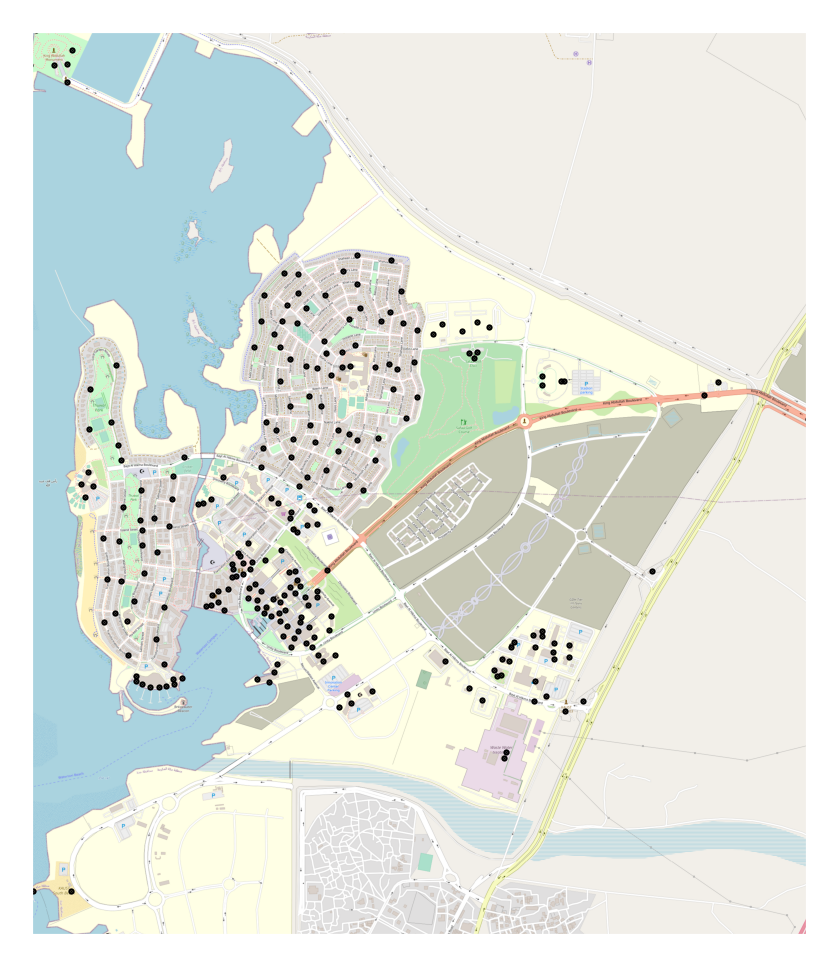

In [108]:
fig = plt.figure(figsize=(4,4), dpi=300) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street ma
extent = [min(longitudes), \
          max(longitudes), \
          min(latitudes), \
          max(latitudes)] # adjust to zoom
ax1.set_extent(extent) # set extents

scale = 16
ax1.add_image(osm_img, scale) # add OSM with zoom specification
# NOTE: zoom specifications should be selected based on extent:
# -- 2     = coarse image, select for worldwide or continental scales
# -- 4-6   = medium coarseness, select for countries and larger states
# -- 6-10  = medium fineness, select for smaller states, regions, and cities
# -- 10-12 = fine image, select for city boundaries and zip codes
# -- 14+   = extremely fine image, select for roads, blocks, buildings

ax1.plot(longitudes, latitudes, markersize= 0.5 ,marker='o',linestyle='',color='black',transform=ccrs.PlateCarree())
plt.savefig('./mapout/kaust_map.pdf', dpi=300)
plt.show() # show the plot

In [6]:
import utm
# Convert to UTM
c = len(latitudes)

X = []
Y = []
for m in range(c):
    x,y, w_, w__ = utm.from_latlon( latitudes[m], longitudes[m])
    X.append(x)
    Y.append(y)
    
X = X - np.mean(X)
Y = Y - np.mean(Y)
data_xy = {'X':X, 'Y':Y}
 
# Create DataFrame
df = pd.DataFrame(data_xy)
df.to_csv('./data/kaust_xy.csv')

In [7]:
import numpy as np
import pandas as pd

In [8]:
DB = {}
B = 20 #MHz; bandwidth of each block
M = 10 #number of f-blocks
d_max = 1000 #m; max distance between two neighbors
epsilon = -1e-5
alpha = 2.5
noise = 1e-5
P = 10 #W
R = 300.0 #m
N_ITER = 100
turn_count = 100

In [9]:
class Node:
  def __init__(self, x, y, ID):
    self.x = x
    self.y = y
    self.ID = str(ID)
    self.neighbors = {}
    self.neighbor_nodes = []
    self.BSI = None
    self.datarate_min = None

  def init_BSI(self):
    self.BSI = np.ones(M, dtype='float64')

  def publish_BSI(self, DB):
    DB[self.ID] = self.BSI

  def add_neighbor(self, ID, d):
    self.neighbors[str(ID)] = d
    self.neighbor_nodes.append(ID)

  def update_BSI(self, N, DB, node_list):
    if len(self.neighbor_nodes)>0:
        # collect the BSI of neighbors and scale them by 1/distance^2
        score = np.zeros(M, dtype='float64')
        for nn in self.neighbor_nodes:
            # suggestion from the neighbours
            this_BSI = -np.power(max(1,self.neighbors[str(nn)]), -alpha)*DB[str(nn)]
            score = score + this_BSI

        # update the BSI by occupying the positive scores
        not_chosen = []

        # social learning
        for m in range(M):
            if score[m] > epsilon:
                self.BSI[m] = 1.0
            else:
                self.BSI[m] = -1.0
                not_chosen.append(m)

        # check if the datarate requirements are satisfied:
        # by calculating the performance in each f-block
        self.publish_BSI(DB)
        datarate_achieved = get_datarate(int(self.ID), N, node_list)

        # self learning
        while len(not_chosen) > 2: 
            if datarate_achieved >= self.min_datarate:
                break

            k_max = not_chosen[np.random.randint(len(not_chosen))]
            self.BSI[k_max] = 1.0
            not_chosen.remove(k_max)

            self.publish_BSI(DB)
            datarate_achieved = get_datarate(int(self.ID), N, node_list)            

    self.publish_BSI(DB)
    


In [10]:
def get_datarates(opt, N, node_list):
    datarate = np.zeros(N, dtype='float64')
    SE = np.zeros(N, dtype='float64') # average spectral efficiency
    n_iter = 1000

    for iter in range(n_iter):
        H = np.random.exponential(1, (N, N))

    for i in range(N):
        for j in range(N):
            H[i][j] = H[j][i] 
    
    for i in range(N):
        BSI_i = node_list[i].BSI
        c = 0
        for m in range(M):
            if BSI_i[m] > 0:
                I_power = 0.0
                for j in range(N):
                    if j!=i:
                        if node_list[j].BSI[m] > 0:
                            d = distance(i, j, node_list)
                            I_power += H[i][j]*P*np.power(max(1.0,d), -alpha)

                SINR = H[i][i]*P*np.power(max(1.0,R), -alpha)/(noise + I_power)
                datarate[i] += B*np.log2(1 + SINR) 
                c += 1
                SE[i] += datarate[i]/(c*B)
    if opt:
        return datarate/n_iter
    return SE/n_iter


def get_datarate(i, N, node_list):
    datarate = 0.0
    BSI_i = node_list[i].BSI
    for m in range(M):
        if BSI_i[m] > 0:
            I_power = 0.0
            for j in range(N):
                if j!=i:
                    if node_list[j].BSI[m] > 0:
                        d = distance(i, j, node_list)
                        I_power += P*np.power(max(1.0,d), -alpha)
            SINR = P*np.power(max(1.0,R), -alpha)/(noise + I_power)
            datarate += B*np.log2(1 + SINR)

    return datarate


def get_datarates_all(opt, N, node_list):
    n_iter = N_ITER
    datarate = np.zeros((N, n_iter), dtype='float64')
    SE = np.zeros((N, n_iter), dtype='float64')

    for iter in range(n_iter):
        H = np.random.exponential(1, (N, N))

        for i in range(N):
            for j in range(N):
                H[i][j] = H[j][i] 

        for i in range(N):
            BSI_i = node_list[i].BSI
            c = 0
            for m in range(M):
                if BSI_i[m] > 0:
                    I_power = 0.0
                    for j in range(N):
                        if j!=i:
                            if node_list[j].BSI[m] > 0:
                                d = distance(i, j, node_list)
                                I_power += H[i][j]*P*np.power(max(1.0,d), -alpha)
                    SINR = H[i][i]*P*np.power(max(1.0,R), -alpha)/(noise + I_power)
                    datarate[i][iter] += B*np.log2(1 + SINR)
                    c+= 1 
                SE[i][iter] += datarate[i][iter]/(c*B)

    if opt:
        return SE

    return datarate

In [11]:
def distance(i, j, node_list):
    x_i = node_list[i].x
    y_i = node_list[i].y
    x_j = node_list[j].x
    y_j = node_list[j].y
    
    return np.sqrt( np.square(x_i-x_j) + np.square(y_i-y_j) )

In [12]:
def play_grid():
    DB = {}
    node_list = []
    
    data = pd.read_csv('./data/kaust_xy.csv')
    X = list(data['X'])
    Y = list(data['Y'])
    N = len(X)

    for i in range(N):
        node_list.append(Node(X[i], Y[i], i))
        
    for i in range(N):
        for j in range(i+1, N):
            d = distance(i, j, node_list)
            
            if d < d_max:
                node_list[i].add_neighbor(j, d)
                node_list[j].add_neighbor(i, d)
                
    # init BSI of all nodes
    for i in range(N):
        node_list[i].init_BSI()
        node_list[i].publish_BSI(DB)
        
    # set min datarate requirement
    for i in range(N):
        node_list[i].min_datarate = get_datarate(i, N, node_list)
        
    # create a Trigger Poisson sequence
    poisson_triggers = list(np.random.randint(N, size=turn_count*N))
    
    # greedy results
    D_greedy = get_datarates_all(0, N, node_list)
    
    # sequential decisions
    for i in poisson_triggers:
        node_list[i].update_BSI(N, DB, node_list)
    
    # democratic results
    D_demo = get_datarates_all(0, N, node_list)
    
    np.savetxt("./data/datarates/greedy_kaust.csv", \
               D_greedy, delimiter=",")
    np.savetxt("./data/datarates/demo_kaust.csv", \
               D_demo, delimiter=",")
    

In [13]:
# play_grid()

In [14]:
file = open("./data/datarates/greedy_kaust.csv",)
D_greedy = np.mean(np.transpose(np.nan_to_num(np.loadtxt(file, delimiter=","))), axis=0)
file.close()

file = open("./data/datarates/demo_kaust.csv",)
D_demo = np.mean(np.transpose(np.nan_to_num(np.loadtxt(file, delimiter=","))), axis=0)
file.close()

In [15]:
def fairness(vec1):
     return np.square(np.sum(vec1))/(c*np.sum(np.square(vec1)))

In [16]:
f_greedy = fairness(D_greedy)

In [17]:
f_demo = fairness(D_demo)

In [18]:
print(f_greedy, f_demo)

0.26481564649461514 0.32101085809536256


In [19]:
print(np.sum(D_greedy), np.sum(D_demo))

1535.8126853182494 2121.8837401749256


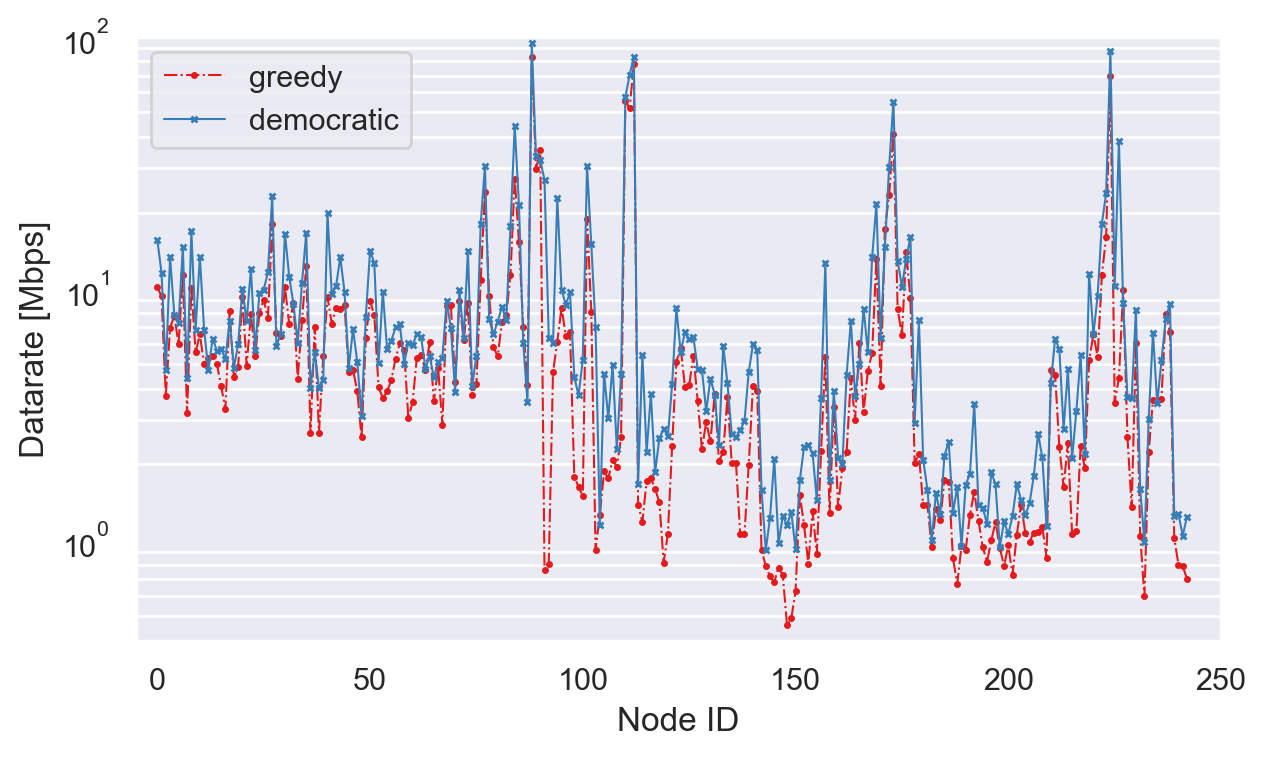

In [123]:
import seaborn as sns
sns.set_theme()

fig = plt.figure(figsize=(7,4), dpi=200)
sns.set_palette(sns.color_palette("Set1"))
plt.semilogy(D_greedy, '.-.', label='greedy', lw=0.75, markersize=3)
plt.semilogy(D_demo, 'x-', label='democratic', lw=0.75, markersize=2)
plt.legend()
plt.ylabel('Datarate [Mbps]')
plt.xlabel('Node ID')
plt.grid(which='both')
plt.ylim(0.4, 100)
plt.xlim(-5, 250)
plt.savefig('./mapout/kaust_diff.pdf', dpi=300)

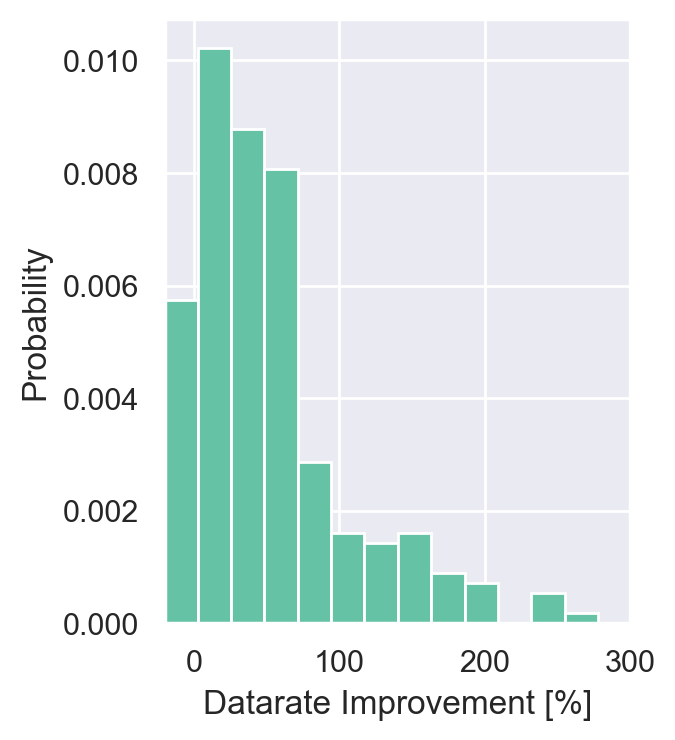

In [120]:
D_improve = np.divide(D_demo - D_greedy, D_greedy)

fig = plt.figure(figsize=(3,4), dpi=200)
sns.set_palette(sns.color_palette("Set2"))
plt.hist( 100*D_improve, bins=150, density=True)
plt.xlabel('Datarate Improvement [%]')
plt.ylabel('Probability')
plt.grid(True)
plt.xlim(-20,300)
plt.savefig('./mapout/kaust_improve.pdf', dpi=300)

In [124]:
len(D_improve)

243

In [125]:
extent

[39.0883009, 39.1382314, 22.2897669, 22.3435258]